In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

In [2]:
df = pd.read_csv('../sat.trn',header=None,sep = '\s')

In [3]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

# 7-> 6 and 1-6 -> 0:5
y[y==7] = 6
for i in range(6):
    y[y == (i + 1)] = i

In [4]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [5]:
numbers = [*range(6)]
list_y = y.tolist()
digits_indexes = []
for digit in numbers:
    li = [i for i in range(len(list_y)) if list_y[i] == digit]
    print(digit, len(li))

0 1072
1 479
2 961
3 415
4 470
5 1038


In [6]:
def get_winner(class1, class2):
    
    numbers = [*range(6)] # number 2 > number 1
    number_of_classification = 2

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])


    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i == class1:
            class1_indexes.extend(digits_indexes[i])
        elif i == class2:
            class2_indexes.extend(digits_indexes[i])

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = len(class1_label) + len(class2_label)
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            pred_outputs = np.argmax(px_outputs, axis = 1)
            real_outputs = np.array(x_outputs).reshape(samplesize,)

            acc = np.sum(pred_outputs == real_outputs)/samplesize

            genome.fitness = acc

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 20)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-satellite2")
    [stats, winner] = run(config_path)
    
    return winner

In [7]:
winner_list = []

for class1 in range(0,5):
    for class2 in range(class1+1,6):
        winner = get_winner(class1, class2)
        winner_list.append(winner)

number of class1:1072
number of class2:479

 ****** Running generation 0 ****** 

Population's average fitness: 0.42715 stdev: 0.21640
Best fitness: 0.96454 - size: (2, 7) - species 1 - id 2
Average adjusted fitness: 0.387
Mean genetic distance 2.794, standard deviation 0.460
Population of 201 members in 16 species
Total extinctions: 0
Generation time: 4.472 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.51602 stdev: 0.23687
Best fitness: 0.96454 - size: (2, 7) - species 1 - id 2
Average adjusted fitness: 0.500
Mean genetic distance 2.897, standard deviation 0.517
Population of 203 members in 20 species
Total extinctions: 0
Generation time: 3.917 sec (4.194 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.55803 stdev: 0.26003
Best fitness: 0.98066 - size: (3, 9) - species 19 - id 555
Average adjusted fitness: 0.521
Mean genetic distance 2.908, standard deviation 0.545
Population of 202 members in 21 species
Total extinctions: 0

Population's average fitness: 0.53553 stdev: 0.12423
Best fitness: 0.95180 - size: (4, 11) - species 4 - id 543
Average adjusted fitness: 0.490
Mean genetic distance 3.070, standard deviation 0.551
Population of 199 members in 31 species
Total extinctions: 0
Generation time: 6.662 sec (5.561 average)

 ****** Running generation 5 ****** 

Population's average fitness: 0.54408 stdev: 0.12331
Best fitness: 0.95180 - size: (4, 11) - species 27 - id 543
Average adjusted fitness: 0.383
Mean genetic distance 3.121, standard deviation 0.547
Population of 202 members in 33 species
Total extinctions: 0
Generation time: 6.317 sec (5.687 average)

 ****** Running generation 6 ****** 

Population's average fitness: 0.54774 stdev: 0.12903
Best fitness: 0.96016 - size: (5, 12) - species 21 - id 1045
Average adjusted fitness: 0.478
Mean genetic distance 3.099, standard deviation 0.541
Population of 199 members in 33 species
Total extinctions: 0
Generation time: 6.461 sec (5.797 average)

 ****** Runn

Population's average fitness: 0.61016 stdev: 0.22329
Best fitness: 0.97646 - size: (4, 10) - species 30 - id 906
Average adjusted fitness: 0.320
Mean genetic distance 2.989, standard deviation 0.476
Population of 205 members in 35 species
Total extinctions: 0
Generation time: 5.586 sec (4.487 average)

 ****** Running generation 9 ****** 

Population's average fitness: 0.58494 stdev: 0.23643
Best fitness: 0.97646 - size: (4, 10) - species 30 - id 906
Average adjusted fitness: 0.491
Mean genetic distance 3.013, standard deviation 0.483
Population of 201 members in 36 species
Total extinctions: 0
Generation time: 4.881 sec (4.526 average)

 ****** Running generation 10 ****** 

Population's average fitness: 0.59943 stdev: 0.24080
Best fitness: 0.97646 - size: (4, 10) - species 30 - id 906
Average adjusted fitness: 0.444
Mean genetic distance 3.011, standard deviation 0.486
Population of 206 members in 36 species
Total extinctions: 0
Generation time: 5.750 sec (4.695 average)

 ****** Run


Population's average fitness: 0.61188 stdev: 0.20375
Best fitness: 0.93191 - size: (5, 15) - species 32 - id 1320
Average adjusted fitness: 0.432
Mean genetic distance 3.124, standard deviation 0.493
Population of 201 members in 41 species
Total extinctions: 0
Generation time: 5.596 sec (5.555 average)

 ****** Running generation 13 ****** 

Population's average fitness: 0.59801 stdev: 0.21092
Best fitness: 0.93191 - size: (5, 15) - species 32 - id 1320
Average adjusted fitness: 0.525
Mean genetic distance 3.123, standard deviation 0.497
Population of 206 members in 41 species
Total extinctions: 0
Generation time: 6.288 sec (5.708 average)

 ****** Running generation 14 ****** 

Population's average fitness: 0.59115 stdev: 0.21342
Best fitness: 0.93191 - size: (5, 15) - species 32 - id 1320
Average adjusted fitness: 0.431
Mean genetic distance 3.137, standard deviation 0.498
Population of 204 members in 42 species
Total extinctions: 0
Generation time: 6.341 sec (5.829 average)

 *****

Population's average fitness: 0.58309 stdev: 0.16257
Best fitness: 0.98720 - size: (2, 10) - species 9 - id 645
Average adjusted fitness: 0.102
Mean genetic distance 3.126, standard deviation 0.558
Population of 195 members in 23 species
Total extinctions: 0
Generation time: 6.588 sec (7.105 average)

 ****** Running generation 17 ****** 

Population's average fitness: 0.58590 stdev: 0.17027
Best fitness: 0.98720 - size: (2, 10) - species 9 - id 645
Average adjusted fitness: 0.296
Mean genetic distance 3.168, standard deviation 0.542
Population of 202 members in 23 species
Total extinctions: 0
Generation time: 6.687 sec (7.178 average)

 ****** Running generation 18 ****** 

Population's average fitness: 0.57477 stdev: 0.17020
Best fitness: 0.98720 - size: (2, 10) - species 9 - id 645
Average adjusted fitness: 0.436
Mean genetic distance 3.154, standard deviation 0.530
Population of 202 members in 24 species
Total extinctions: 0
Generation time: 7.055 sec (7.097 average)

 ****** Runni


 ****** Running generation 0 ****** 

Population's average fitness: 0.48262 stdev: 0.14731
Best fitness: 0.96644 - size: (2, 7) - species 5 - id 58
Average adjusted fitness: 0.424
Mean genetic distance 2.826, standard deviation 0.497
Population of 201 members in 17 species
Total extinctions: 0
Generation time: 2.480 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52695 stdev: 0.16086
Best fitness: 0.97651 - size: (3, 9) - species 2 - id 272
Average adjusted fitness: 0.446
Mean genetic distance 2.914, standard deviation 0.520
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 2.599 sec (2.539 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.52943 stdev: 0.16801
Best fitness: 0.97651 - size: (3, 9) - species 5 - id 272
Average adjusted fitness: 0.498
Mean genetic distance 3.036, standard deviation 0.527
Population of 203 members in 27 species
Total extinctions: 0
Generation time: 2.579 sec (2.552 averag

Population's average fitness: 0.56816 stdev: 0.15507
Best fitness: 0.92308 - size: (4, 10) - species 14 - id 809
Average adjusted fitness: 0.445
Mean genetic distance 3.039, standard deviation 0.544
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 3.187 sec (3.131 average)

 ****** Running generation 5 ****** 

Population's average fitness: 0.58758 stdev: 0.15483
Best fitness: 0.92308 - size: (4, 10) - species 14 - id 809
Average adjusted fitness: 0.474
Mean genetic distance 3.061, standard deviation 0.543
Population of 205 members in 33 species
Total extinctions: 0
Generation time: 3.524 sec (3.196 average)

 ****** Running generation 6 ****** 

Population's average fitness: 0.60685 stdev: 0.17004
Best fitness: 0.92308 - size: (4, 10) - species 14 - id 809
Average adjusted fitness: 0.429
Mean genetic distance 3.097, standard deviation 0.537
Population of 204 members in 34 species
Total extinctions: 0
Generation time: 3.538 sec (3.245 average)

 ****** Runn


Population's average fitness: 0.68053 stdev: 0.23079
Best fitness: 0.98484 - size: (5, 14) - species 14 - id 1374
Average adjusted fitness: 0.631
Mean genetic distance 3.150, standard deviation 0.496
Population of 190 members in 42 species
Total extinctions: 0
Generation time: 5.574 sec (4.592 average)

 ****** Running generation 9 ****** 

Population's average fitness: 0.69485 stdev: 0.24781
Best fitness: 0.98484 - size: (5, 14) - species 14 - id 1374
Average adjusted fitness: 0.607
Mean genetic distance 3.178, standard deviation 0.499
Population of 197 members in 42 species
Total extinctions: 0
Generation time: 5.483 sec (4.681 average)

 ****** Running generation 10 ****** 

Population's average fitness: 0.68941 stdev: 0.22700
Best fitness: 0.98748 - size: (3, 8) - species 30 - id 1632
Average adjusted fitness: 0.439
Mean genetic distance 3.172, standard deviation 0.505
Population of 189 members in 42 species
Total extinctions: 0
Generation time: 5.639 sec (4.890 average)

 ****** 

Population's average fitness: 0.56362 stdev: 0.18661
Best fitness: 0.71584 - size: (2, 7) - species 7 - id 488
Average adjusted fitness: 0.266
Mean genetic distance 2.946, standard deviation 0.504
Population of 206 members in 33 species
Total extinctions: 0
Generation time: 5.214 sec (4.427 average)

 ****** Running generation 13 ****** 

Population's average fitness: 0.56198 stdev: 0.18888
Best fitness: 0.71584 - size: (2, 7) - species 7 - id 488
Average adjusted fitness: 0.263
Mean genetic distance 2.931, standard deviation 0.513
Population of 205 members in 33 species
Total extinctions: 0
Generation time: 5.282 sec (4.580 average)

 ****** Running generation 14 ****** 

Population's average fitness: 0.59664 stdev: 0.17373
Best fitness: 0.71584 - size: (2, 7) - species 7 - id 488
Average adjusted fitness: 0.280
Mean genetic distance 2.949, standard deviation 0.511
Population of 198 members in 33 species
Total extinctions: 0
Generation time: 4.975 sec (4.694 average)

 ****** Running 

Population's average fitness: 0.60302 stdev: 0.20449
Best fitness: 0.93361 - size: (6, 10) - species 33 - id 1735
Average adjusted fitness: 0.407
Mean genetic distance 3.167, standard deviation 0.548
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 5.570 sec (5.076 average)

 ****** Running generation 17 ****** 

Population's average fitness: 0.60410 stdev: 0.20678
Best fitness: 0.93361 - size: (6, 10) - species 33 - id 1735
Average adjusted fitness: 0.466
Mean genetic distance 3.176, standard deviation 0.535
Population of 190 members in 32 species
Total extinctions: 0
Generation time: 4.860 sec (5.006 average)

 ****** Running generation 18 ****** 

Population's average fitness: 0.61367 stdev: 0.20198
Best fitness: 0.93361 - size: (6, 10) - species 33 - id 1735
Average adjusted fitness: 0.327
Mean genetic distance 3.183, standard deviation 0.528
Population of 208 members in 29 species
Total extinctions: 0
Generation time: 4.511 sec (4.916 average)

 ******

Population's average fitness: 0.51675 stdev: 0.06829
Best fitness: 0.84520 - size: (2, 7) - species 2 - id 194
Average adjusted fitness: 0.306
Mean genetic distance 2.867, standard deviation 0.511
Population of 201 members in 19 species
Total extinctions: 0
Generation time: 3.038 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.51931 stdev: 0.07446
Best fitness: 0.84520 - size: (2, 7) - species 8 - id 194
Average adjusted fitness: 0.402
Mean genetic distance 2.972, standard deviation 0.547
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 3.428 sec (3.233 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.52836 stdev: 0.06810
Best fitness: 0.86328 - size: (3, 8) - species 10 - id 411
Average adjusted fitness: 0.306
Mean genetic distance 2.943, standard deviation 0.549
Population of 201 members in 23 species
Total extinctions: 0
Generation time: 3.081 sec (3.183 average)

 ****** Running generation 3 ****

Population's average fitness: 0.65904 stdev: 0.13873
Best fitness: 0.72127 - size: (3, 9) - species 2 - id 371
Average adjusted fitness: 0.354
Mean genetic distance 2.954, standard deviation 0.545
Population of 197 members in 24 species
Total extinctions: 0
Generation time: 4.823 sec (4.393 average)

 ****** Running generation 5 ****** 

Population's average fitness: 0.65441 stdev: 0.14661
Best fitness: 0.72333 - size: (5, 15) - species 13 - id 1008
Average adjusted fitness: 0.373
Mean genetic distance 2.975, standard deviation 0.534
Population of 196 members in 26 species
Total extinctions: 0
Generation time: 4.083 sec (4.341 average)

 ****** Running generation 6 ****** 

Population's average fitness: 0.64856 stdev: 0.14716
Best fitness: 0.72333 - size: (5, 15) - species 26 - id 1008
Average adjusted fitness: 0.352
Mean genetic distance 3.025, standard deviation 0.538
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 4.098 sec (4.306 average)

 ****** Runn

Population's average fitness: 0.62496 stdev: 0.19002
Best fitness: 0.90318 - size: (5, 14) - species 26 - id 1047
Average adjusted fitness: 0.363
Mean genetic distance 3.010, standard deviation 0.535
Population of 206 members in 35 species
Total extinctions: 0
Generation time: 6.665 sec (4.558 average)

 ****** Running generation 9 ****** 

Population's average fitness: 0.62897 stdev: 0.18633
Best fitness: 0.90318 - size: (5, 14) - species 26 - id 1047
Average adjusted fitness: 0.418
Mean genetic distance 3.065, standard deviation 0.535
Population of 205 members in 35 species
Total extinctions: 0
Generation time: 4.742 sec (4.577 average)

 ****** Running generation 10 ****** 

Population's average fitness: 0.60977 stdev: 0.19816
Best fitness: 0.90318 - size: (5, 14) - species 26 - id 1047
Average adjusted fitness: 0.408
Mean genetic distance 3.078, standard deviation 0.542
Population of 203 members in 36 species
Total extinctions: 0
Generation time: 4.769 sec (4.641 average)

 ****** 

In [8]:
classes = []
for class1 in range(0,5):
    for class2 in range(class1+1, 6):
        classes.append([class1, class2])

In [9]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-satellite2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [10]:
test_df = pd.read_csv('../sat.tst',header=None,sep = '\s')

testX = test_df.iloc[:,:-1].to_numpy()
testy = test_df.iloc[:,-1].to_numpy()

# 7-> 6 and 1-6 -> 0:5
testy[testy==7] = 6
for i in range(6):
    testy[testy == (i + 1)] = i

In [11]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(6)]
    class1, class2 = classes[i]
    
    class1_indexes = []
    class2_indexes = []
    
    test_X = testX[j]
    test_y = testy[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i == class1:
            class1_indexes.extend(digits_indexes[i])
        elif i == class2:
            class2_indexes.extend(digits_indexes[i])

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    
    
    return pred_outputs

In [12]:
# 这里反而pred-outputs 的0 是第二类(id是1)，1是第一类（id是0）
pred_value = []

for j in range(2000):
    pred = []
    vote = [0,0,0,0,0,0]
    for i in range(15):
        pred_outputs = get_pred_real(i, j)
        #print(i,classes[i],pred_outputs[0][0])
        vote_for = classes[i][1 - pred_outputs[0]]
        vote[vote_for] += 1 #1 is class 1(id:0) and 0 is class 2(id:1)
    pred_value.append(np.where(vote==np.max(vote)))        
    #print(np.array(pred).T)

In [13]:
from random import randint
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])

In [14]:
np.sum(list_P == testy)/2000

0.714

In [15]:
for i,p_value in enumerate(pred_value):
    print("#{} index:{} real:{}".format(i, p_value[0], testy[i]))

#0 index:[2] real:2
#1 index:[2] real:2
#2 index:[2] real:3
#3 index:[2] real:3
#4 index:[2] real:3
#5 index:[2] real:3
#6 index:[2] real:3
#7 index:[2] real:3
#8 index:[5] real:3
#9 index:[2] real:3
#10 index:[2] real:3
#11 index:[2] real:3
#12 index:[5] real:3
#13 index:[2] real:3
#14 index:[2] real:2
#15 index:[2] real:2
#16 index:[2] real:2
#17 index:[2] real:2
#18 index:[2] real:2
#19 index:[2] real:2
#20 index:[2] real:2
#21 index:[2] real:2
#22 index:[2] real:2
#23 index:[5] real:2
#24 index:[5] real:2
#25 index:[2] real:2
#26 index:[5] real:2
#27 index:[4] real:4
#28 index:[2] real:5
#29 index:[5] real:5
#30 index:[5] real:5
#31 index:[4] real:4
#32 index:[2] real:2
#33 index:[2] real:2
#34 index:[2] real:3
#35 index:[2] real:3
#36 index:[2] real:3
#37 index:[2] real:3
#38 index:[2] real:3
#39 index:[5] real:3
#40 index:[5] real:3
#41 index:[0] real:3
#42 index:[2] real:2
#43 index:[2] real:2
#44 index:[5] real:2
#45 index:[2] real:2
#46 index:[2] real:2
#47 index:[2] real:2
#4

#553 index:[4 5] real:1
#554 index:[1] real:1
#555 index:[1] real:1
#556 index:[1] real:1
#557 index:[1] real:1
#558 index:[1] real:1
#559 index:[2 3 5] real:5
#560 index:[5] real:5
#561 index:[5] real:5
#562 index:[5] real:5
#563 index:[5] real:5
#564 index:[5] real:5
#565 index:[2] real:5
#566 index:[2 3 5] real:5
#567 index:[2 3 5] real:5
#568 index:[5] real:5
#569 index:[5] real:4
#570 index:[4] real:4
#571 index:[4] real:4
#572 index:[4] real:4
#573 index:[4] real:4
#574 index:[4] real:4
#575 index:[4] real:4
#576 index:[4] real:4
#577 index:[1] real:1
#578 index:[1] real:1
#579 index:[5] real:3
#580 index:[5] real:3
#581 index:[2] real:3
#582 index:[5] real:3
#583 index:[2] real:2
#584 index:[2] real:2
#585 index:[5] real:2
#586 index:[1] real:1
#587 index:[4] real:1
#588 index:[5] real:5
#589 index:[2 3 5] real:5
#590 index:[5] real:5
#591 index:[2 5] real:5
#592 index:[2] real:5
#593 index:[2 3 5] real:5
#594 index:[2] real:5
#595 index:[4] real:4
#596 index:[4] real:4
#597 ind

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, testy)
print(cm)

[[445   2   2   3  23   2]
 [  0 197   0   0   5   0]
 [  6   4 279  90   6  94]
 [  0   1  10  16   1  24]
 [  9  17   0   2 148   7]
 [  1   3 106 100  54 343]]


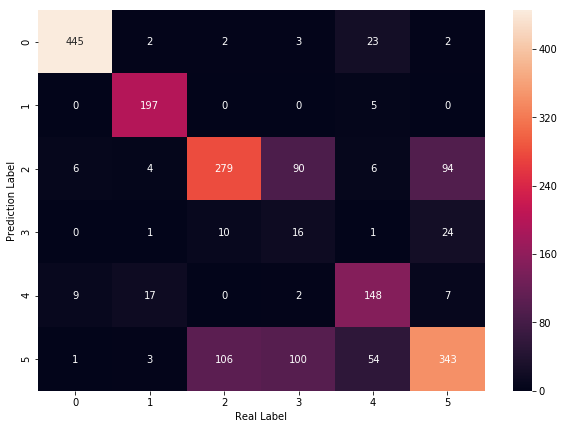

In [17]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in "012345"],
                  columns = [i for i in "012345"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='.20g', annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()